## 2/4/2026

In [84]:
import sys
sys.path.append('/Users/iemotoyuni/Desktop/SpenderQ/SpenderQ_Clone/SpenderQ/src')

from spenderq.spenderq import SpenderQ
import torch
import numpy as np
import pandas as pd
from astropy.io import fits
from desispec.io import read_spectra
from desispec.io.fibermap import read_fibermap

## open qso_catalog 

In [85]:
filepath = "/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/QSO_cat_iron_cumulative_v0.fits"

with fits.open(filepath) as hdul:
    for i, hdu in enumerate(hdul):
        print(f"\n--- Header for HDU {i} ---")
        print(hdu.header)

# Load FITS table
with fits.open(filepath) as hdul:
    data = hdul[1].data

df = pd.DataFrame(data)

df


--- Header for HDU 0 ---
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

,TARGETID,Z,ZERR,ZWARN,LOCATION,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,EBV,FLUX_G,...,Z_Hbeta,Z_Halpha,QSO_MASKBITS,TILEID,LASTNIGHT,PETAL_LOC,SURVEY,PROGRAM,MORPHTYPE,SPECTYPE
0,39628488923152527,0.404274,0.000011,0,156,0,24.024810,30.483482,0.058635,12.279786,...,0.402122,0.401461,32,80615,20201216,0,cmx,other,SER,QSO
1,39628483692860311,1.377407,0.000353,0,233,0,23.973138,30.320543,0.056153,1.088233,...,0.563821,0.321213,14,80615,20201216,0,cmx,other,PSF,QSO
2,39628488918960626,2.920026,0.000610,0,186,0,23.967261,30.428746,0.058720,0.765419,...,-0.159126,-0.145905,10,80615,20201216,0,cmx,other,PSF,QSO
3,39628483692857098,0.409949,0.000018,0,271,0,23.789290,30.283673,0.056138,13.001515,...,0.414326,0.418013,32,80615,20201216,0,cmx,other,DEV,QSO
4,39628488923152946,2.995917,0.000775,0,184,0,24.050456,30.423308,0.056268,0.760508,...,0.167781,0.171912,10,80615,20201216,0,cmx,other,PSF,QSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182304,39633411484160756,1.780252,0.000754,0,7280,0,290.063424,61.970753,0.063776,4.939600,...,0.311602,0.455658,32,23644,20220613,7,main,bright,DEV,QSO
2182305,39633411484159101,1.306414,0.000229,0,7245,0,289.896907,61.942402,0.073316,7.905850,...,0.581254,-0.246711,14,23644,20220613,7,main,bright,PSF,QSO
2182306,39633402852283800,0.404205,0.000025,0,8377,0,290.653145,61.261675,0.064659,4.810054,...,0.413825,0.392828,32,23644,20220613,8,main,bright,REX,QSO
2182307,39633402856473475,0.362653,0.000031,0,8352,0,290.756963,61.368019,0.056506,16.526506,...,0.356364,0.343744,32,23644,20220613,8,main,bright,SER,QSO


In [ ]:
print(df[['TARGETID', 'TILEID', 'LASTNIGHT']])


# ======= Check multiple TARGETIDs =======
target_ids_to_check = [39627859723032583, 39628488923152527]  # Add or modify TARGETIDs here

for target_id in target_ids_to_check:
    result = df[df['TARGETID'] == target_id]
    if len(result) > 0:
        print(f"\n✓ TARGETID {target_id} found:")
        print(f"  TILEID values: {result['TILEID'].values}")
        print(f"  Z (redshift): {result['Z'].values[0]:.6f}")
        print(f"  LASTNIGHT: {result['LASTNIGHT'].values[0]}")
    else:
        print(f"\n✗ TARGETID {target_id} not found in catalog")

                  TARGETID  TILEID  LASTNIGHT
0        39628488923152527   80615   20201216
1        39628483692860311   80615   20201216
2        39628488918960626   80615   20201216
3        39628483692857098   80615   20201216
4        39628488923152946   80615   20201216
...                    ...     ...        ...
2182304  39633411484160756   23644   20220613
2182305  39633411484159101   23644   20220613
2182306  39633402852283800   23644   20220613
2182307  39633402856473475   23644   20220613
2182308  39633391003371313   23644   20220613

[2182309 rows x 3 columns]
TILEID values for TARGETID 39627859723032583:
[80609     1     2     6     8  8772  5633]


In [ ]:
# ======= Extract all TARGETIDs and their TILEID locations =======
all_targetids = df['TARGETID'].values
all_tileids = df['TILEID'].values
all_z = df['Z'].values

print(f"Total TARGETIDs in catalog: {len(all_targetids)}\n")
print(f"{'Index':<6} {'TARGETID':<20} {'TILEID':<10} {'Z (redshift)':<12}")
print("="*60)

for i, (tid, tileid, z) in enumerate(zip(all_targetids, all_tileids, all_z)):
    print(f"{i:<6} {tid:<20} {tileid:<10} {z:<12.6f}")

print(f"\n--- To check specific TARGETIDs, use index numbers above ---")
print(f"Example: target_ids_to_check = all_targetids[:5]  # Check first 5")


Total TARGETIDs in catalog: 2182309

First 10 TARGETIDs:
  0: 39628488923152527
  1: 39628483692860311
  2: 39628488918960626
  3: 39628483692857098
  4: 39628488923152946
  5: 39628488918958725
  6: 39628483697050490
  7: 39628483692857482
  8: 39628483692859203
  9: 39628483697052074

--- To check specific TARGETIDs, modify the list above ---
Example: target_ids_to_check = all_targetids[:5]  # Check first 5


## Just coadd-0-10256-thru20211110.fits


In [88]:
# ========== Load DESI Cumulative Coadd Spectra & Redshifts ==========
spec_file = '/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/cumulative/10256/20211110/coadd-0-10256-thru20211110.fits'
cat_file = '/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/QSO_cat_iron_cumulative_v0.fits'

# Load all three bands (B, R, Z) from cumulative coadd
bands = {}
with fits.open(spec_file) as hdul:
    for band in ['B', 'R', 'Z']:
        bands[band] = {
            'wavelength': np.array(hdul[f'{band}_WAVELENGTH'].data, dtype=np.float32),
            'flux_raw': np.array(hdul[f'{band}_FLUX'].data, dtype=np.float32),  # (Nfiber, Nwave)
            'ivar_raw': np.array(hdul[f'{band}_IVAR'].data, dtype=np.float32),  # (Nfiber, Nwave)
        }
    fibermap = hdul['FIBERMAP'].data

print(f'Band info:')
for band in ['B', 'R', 'Z']:
    print(f' {band}: wavelength shape {bands[band]["wavelength"].shape}, flux shape {bands[band]["flux_raw"].shape}')

# Select first 10 spectra for all bands
Nspec = 10
for band in ['B', 'R', 'Z']:
    bands[band]['flux'] = bands[band]['flux_raw'][:Nspec]
    bands[band]['ivar'] = bands[band]['ivar_raw'][:Nspec]

# Get TARGETIDs and redshifts from QSO catalog
targetids_in_fiber = fibermap['TARGETID'][:Nspec]
with fits.open(cat_file) as hdul:
    qso_data = hdul['QSO_CAT'].data
    qso_targetids = qso_data['TARGETID']
    qso_z = qso_data['Z']
    
    # Match TARGETIDs to get redshifts
    z_values = np.zeros(Nspec, dtype=np.float32)
    for i, tid in enumerate(targetids_in_fiber):
        idx = np.where(qso_targetids == tid)[0]
        if len(idx) > 0:
            z_values[i] = qso_z[idx[0]]

print(f'Loaded {Nspec} spectra')
print(f'Redshifts: min={z_values.min():.3f}, max={z_values.max():.3f}, mean={z_values.mean():.3f}')

# Set current band (can change to 'B', 'R', or 'Z')
current_band = 'Z'
wavelength = bands[current_band]['wavelength']
flux = bands[current_band]['flux']
ivar = bands[current_band]['ivar']

# Convert to torch tensors
spec = torch.tensor(flux, dtype=torch.float32)
w = torch.tensor(ivar, dtype=torch.float32)  # weights = inverse variance
z = torch.tensor(z_values, dtype=torch.float32)

print(f'\nUsing {current_band}-band: wavelength shape {wavelength.shape}, flux shape {flux.shape}')

Band info:
 B: wavelength shape (2751,), flux shape (500, 2751)
 R: wavelength shape (2326,), flux shape (500, 2326)
 Z: wavelength shape (2881,), flux shape (500, 2881)
Loaded 10 spectra
Redshifts: min=0.000, max=1.823, mean=0.329

Using Z-band: wavelength shape (2881,), flux shape (10, 2881)


In [89]:
print(fibermap.names)


['TARGETID', 'PETAL_LOC', 'DEVICE_LOC', 'LOCATION', 'FIBER', 'COADD_FIBERSTATUS', 'TARGET_RA', 'TARGET_DEC', 'PMRA', 'PMDEC', 'REF_EPOCH', 'LAMBDA_REF', 'FA_TARGET', 'FA_TYPE', 'OBJTYPE', 'FIBERASSIGN_X', 'FIBERASSIGN_Y', 'PRIORITY', 'SUBPRIORITY', 'OBSCONDITIONS', 'RELEASE', 'BRICKNAME', 'BRICKID', 'BRICK_OBJID', 'MORPHTYPE', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 'MASKBITS', 'SERSIC', 'SHAPE_R', 'SHAPE_E1', 'SHAPE_E2', 'REF_ID', 'REF_CAT', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_MAG', 'PARALLAX', 'PHOTSYS', 'PRIORITY_INIT', 'NUMOBS_INIT', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'SCND_TARGET', 'PLATE_RA', 'PLATE_DEC', 'TILEID', 'COADD_NUMEXP', 'COADD_EXPTIME', 'COADD_NUMNIGHT', 'COADD_NUMTILE', 'MEAN_DELTA_X', 'RMS_DELTA_X', 'MEAN_DELTA_Y', 'RMS_DELTA_Y', 'MEAN_

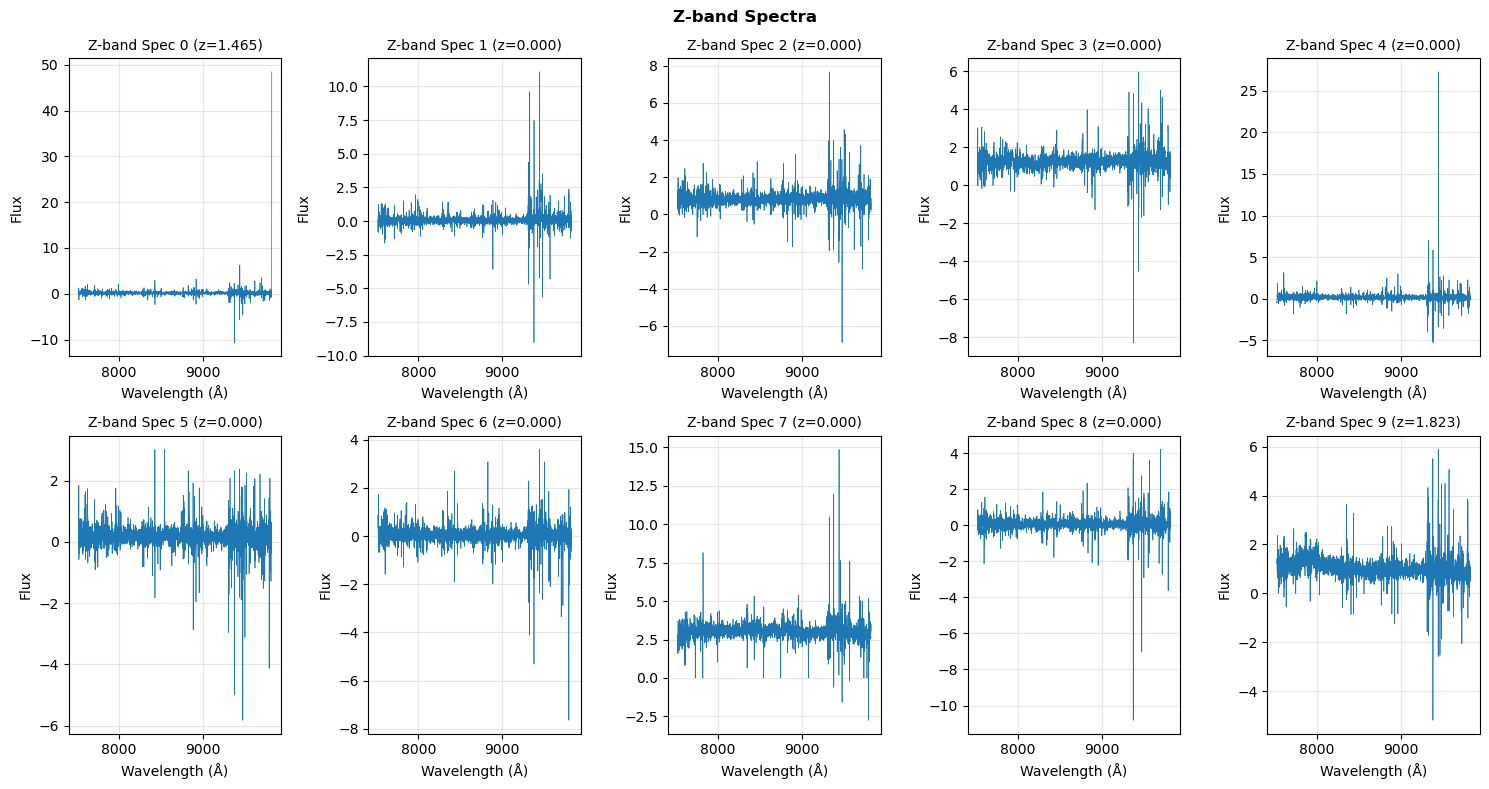

In [95]:
import matplotlib.pyplot as plt

# Plot the spectra for current band
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i in range(min(10, Nspec)):
    ax = axes[i]
    ax.plot(wavelength, flux[i], linewidth=0.5)
    ax.set_title(f'{current_band}-band Spec {i} (z={z_values[i]:.3f})', fontsize=10)
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'{current_band}-band Spectra', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [96]:
import sys
sys.path.append('/Users/iemotoyuni/Desktop/SpenderQ/SpenderQ_Clone/SpenderQ/src')
from spenderq.spenderq import SpenderQ

In [97]:
# ========== Run SpenderQ with error handling ==========
print('Instantiating SpenderQ...')
spender = SpenderQ('qso.dr1.hiz')

print('Running SpenderQ.eval()...')
try:
    s, recon = spender.eval(spec, w, z)
except IndexError as e:
    print(f'IndexError in Lyα absorption: {e}')
    print('Trying encode/decode without Lyα masking...')
    # Just run the first model's encode/decode without iterative refinement
    with torch.no_grad():
        spender.models[0][0].eval()
        s = spender.models[0][0].encode(spec)
        recon = np.array(spender.models[0][0].decode(s))

print(f'Output shapes:')
print(f'  s (latent): {s.shape}')
print(f'  recon: {recon.shape}')
print('Done!')

Instantiating SpenderQ...
Running SpenderQ.eval()...
IndexError in Lyα absorption: boolean index did not match indexed array along dimension 0; dimension is 2881 but corresponding boolean dimension is 7781
Trying encode/decode without Lyα masking...
Output shapes:
  s (latent): torch.Size([10, 10])
  recon: (10, 9780)
Done!


Current band (Z):
  Original wavelength shape: (2881,), Recon wavelength shape: (9780,)
  Original flux shape: (10, 2881), Recon shape: (10, 9780)


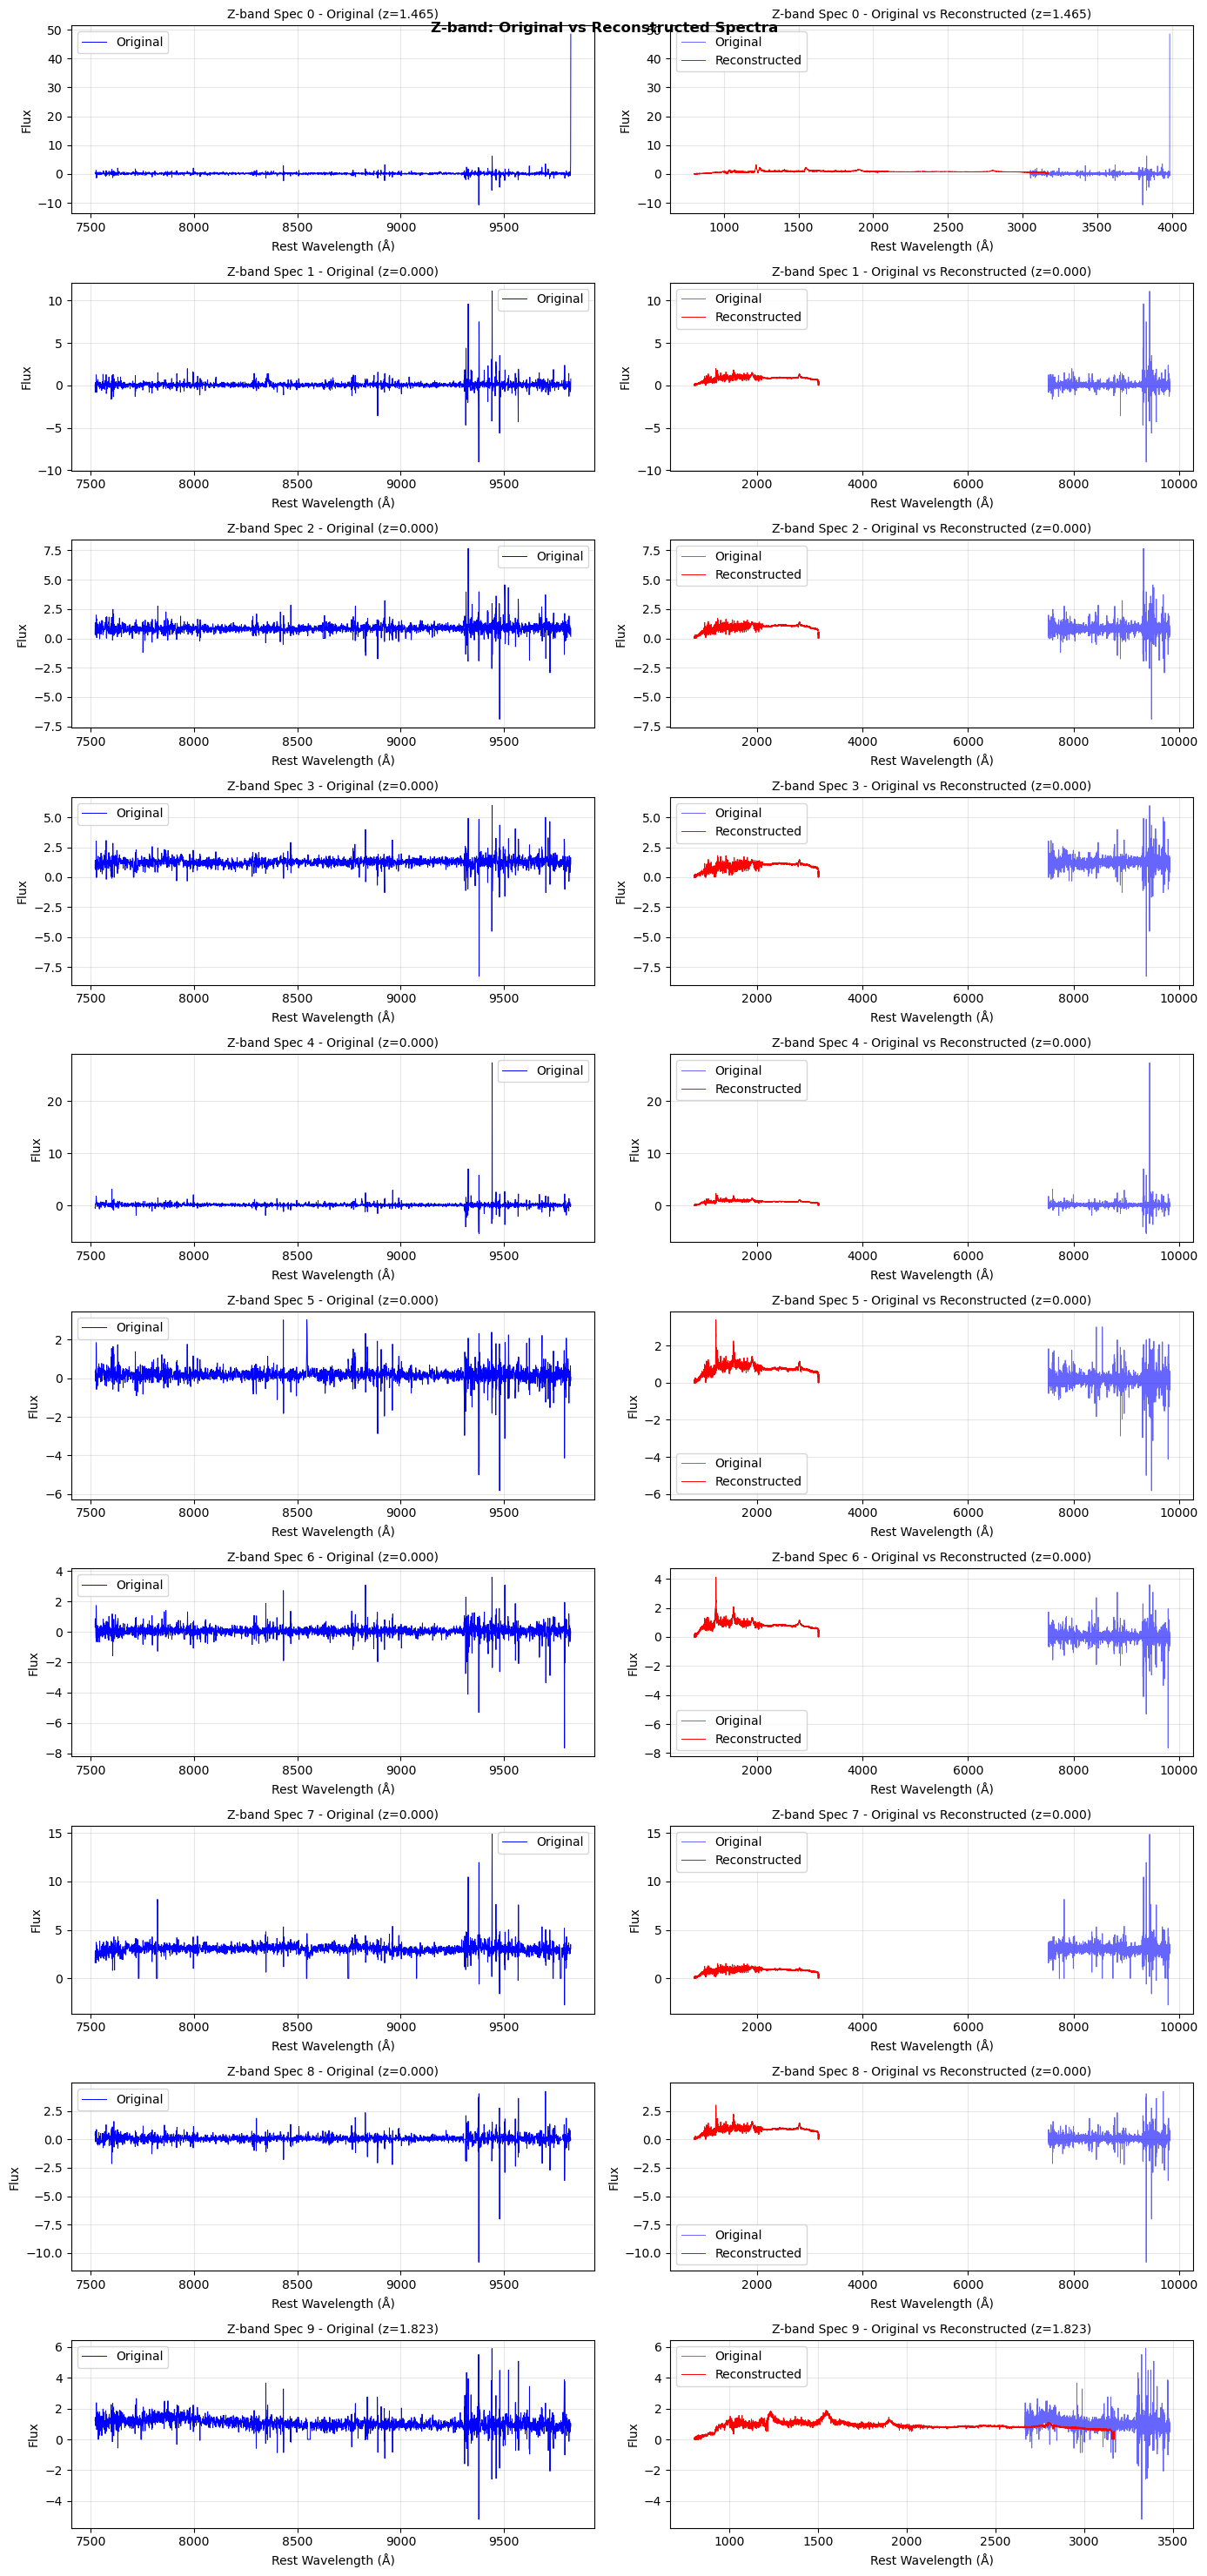

In [99]:
# Get reconstruction wavelength
wave_recon = spender.wave_recon()
print(f'Current band ({current_band}):')
print(f'  Original wavelength shape: {wavelength.shape}, Recon wavelength shape: {wave_recon.shape}')
print(f'  Original flux shape: {flux.shape}, Recon shape: {recon.shape}')

# Plot original vs reconstructed spectra
fig, axes = plt.subplots(Nspec, 2, figsize=(14, 3*Nspec))
if Nspec == 1:
    axes = axes.reshape(1, -1)

for i in range(Nspec):
    
    # Left: Original spectrum in rest frame
    axes[i, 0].plot(wavelength, flux[i], 'b-', linewidth=0.7, label='Original')
    axes[i, 0].set_title(f'{current_band}-band Spec {i} - Original (z={z_values[i]:.3f})', fontsize=10)
    axes[i, 0].set_xlabel('Rest Wavelength (Å)')
    axes[i, 0].set_ylabel('Flux')
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].legend()
    
    # Right: Original and reconstructed overlapped (both in rest frame)
    wave_rest = wavelength / (1.0 + z_values[i])
    axes[i, 1].plot(wave_rest, flux[i], 'b-', linewidth=0.7, label='Original', alpha=0.6)
    axes[i, 1].plot(wave_recon, recon[i], 'r-', linewidth=0.7, label='Reconstructed')
    axes[i, 1].set_title(f'{current_band}-band Spec {i} - Original vs Reconstructed (z={z_values[i]:.3f})', fontsize=10)
    axes[i, 1].set_xlabel('Rest Wavelength (Å)')
    axes[i, 1].set_ylabel('Flux')
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].legend()
    
    
plt.suptitle(f'{current_band}-band: Original vs Reconstructed Spectra', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## coadd-*-6-thru20210417 
### first targetid [39628488923152527] in QSO_cat_iron_cumulative_v0.fits


In [100]:
import os
from pathlib import Path

target_id = 39627859723032583

# Get the tiles where this TARGETID appears
target_tiles = result['TILEID'].values
print(f"TARGETID {target_id} appears in tiles according to catalog: {target_tiles}")
print(f"\nSearching locally in tile 6 only...")

found = False
spectrum_data = None

# Only search in tile 6 (the only one available locally)
tile_6_path = "/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/cumulative/6"

# Look through all subdirectories in tile 6
for root, dirs, files in os.walk(tile_6_path):
    for filename in files:
        if filename.endswith('.fits'):
            filepath = os.path.join(root, filename)
            
            # Try to open and search for TARGETID
            try:
                with fits.open(filepath) as hdul:
                    if 'FIBERMAP' in hdul:
                        fibermap = hdul['FIBERMAP'].data
                        targetids = fibermap['TARGETID']
                        
                        # Check if our target ID is in this file
                        idx = np.where(targetids == target_id)[0]
                        if len(idx) > 0:
                            print(f"✓ Found TARGETID {target_id} in {filename} at fiber index {idx[0]}")
                            
                            # Load spectrum data
                            spectrum_data = {
                                'file': filepath,
                                'fiber_idx': idx[0],
                                'tile_id': 6,
                                'fibermap': fibermap[idx[0]],
                                'bands': {}
                            }
                            
                            # Load all available bands
                            for band in ['B', 'R', 'Z']:
                                if f'{band}_FLUX' in hdul:
                                    spectrum_data['bands'][band] = {
                                        'wavelength': np.array(hdul[f'{band}_WAVELENGTH'].data, dtype=np.float32),
                                        'flux': np.array(hdul[f'{band}_FLUX'].data[idx[0]], dtype=np.float32),
                                        'ivar': np.array(hdul[f'{band}_IVAR'].data[idx[0]], dtype=np.float32)
                                    }
                            
                            found = True
                            break
            except Exception as e:
                print(f"  Error reading {filename}: {e}")
    
    if found:
        break

if found:
    print(f"\n✓✓✓ Spectrum found! ✓✓✓")
    print(f"Tile: {spectrum_data['tile_id']}")
    print(f"File: {spectrum_data['file']}")
    print(f"Fiber index: {spectrum_data['fiber_idx']}")
    print(f"Available bands: {list(spectrum_data['bands'].keys())}")
    print(f"Redshift (from catalog): {result['Z'].values[0]}")
else:
    print(f"\n✗ TARGETID {target_id} not found in tile 6 files")

TARGETID 39627859723032583 appears in tiles according to catalog: [80609     1     2     6     8  8772  5633]

Searching locally in tile 6 only...
✓ Found TARGETID 39627859723032583 in coadd-5-6-thru20210417.fits at fiber index 143

✓✓✓ Spectrum found! ✓✓✓
Tile: 6
File: /Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/cumulative/6/coadd-5-6-thru20210417.fits
Fiber index: 143
Available bands: ['B', 'R', 'Z']
Redshift (from catalog): 2.6480591646715257


r_flux shape: (2326,)
r_flux dtype: float32
r_flux stats: min=0, max=0, median=0

First 200 R-band pixel values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


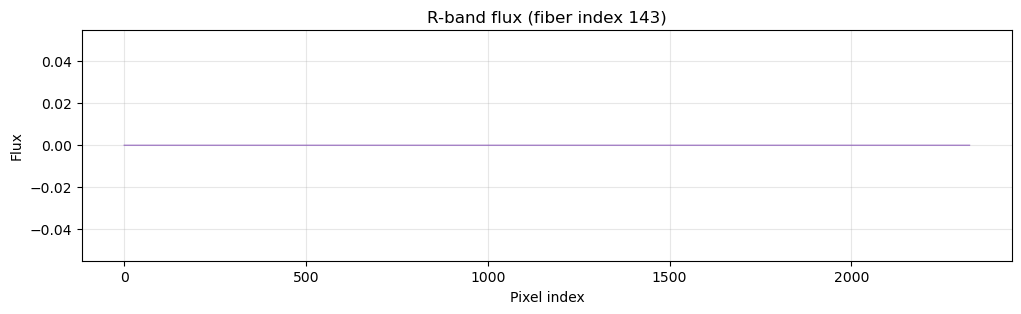

In [101]:
#==== just checking in if R flux is actually 0 ===

# Display and plot the loaded R-band array
if 'r_flux' in globals():
    print('r_flux shape:', r_flux.shape)
    print('r_flux dtype:', r_flux.dtype)
    print('r_flux stats: min=%g, max=%g, median=%g' % (np.nanmin(r_flux), np.nanmax(r_flux), np.nanmedian(r_flux)))
    # print first 200 values
    nshow = min(200, r_flux.size)
    print('\nFirst %d R-band pixel values:' % nshow)
    print(r_flux[:nshow])

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 3))
    plt.plot(r_flux, '-', color='tab:purple', linewidth=0.8)
    plt.title(f'R-band flux (fiber index {spectrum_data["fiber_idx"]})')
    plt.xlabel('Pixel index')
    plt.ylabel('Flux')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print('r_flux is not defined. Run the R-band loader cell first.')

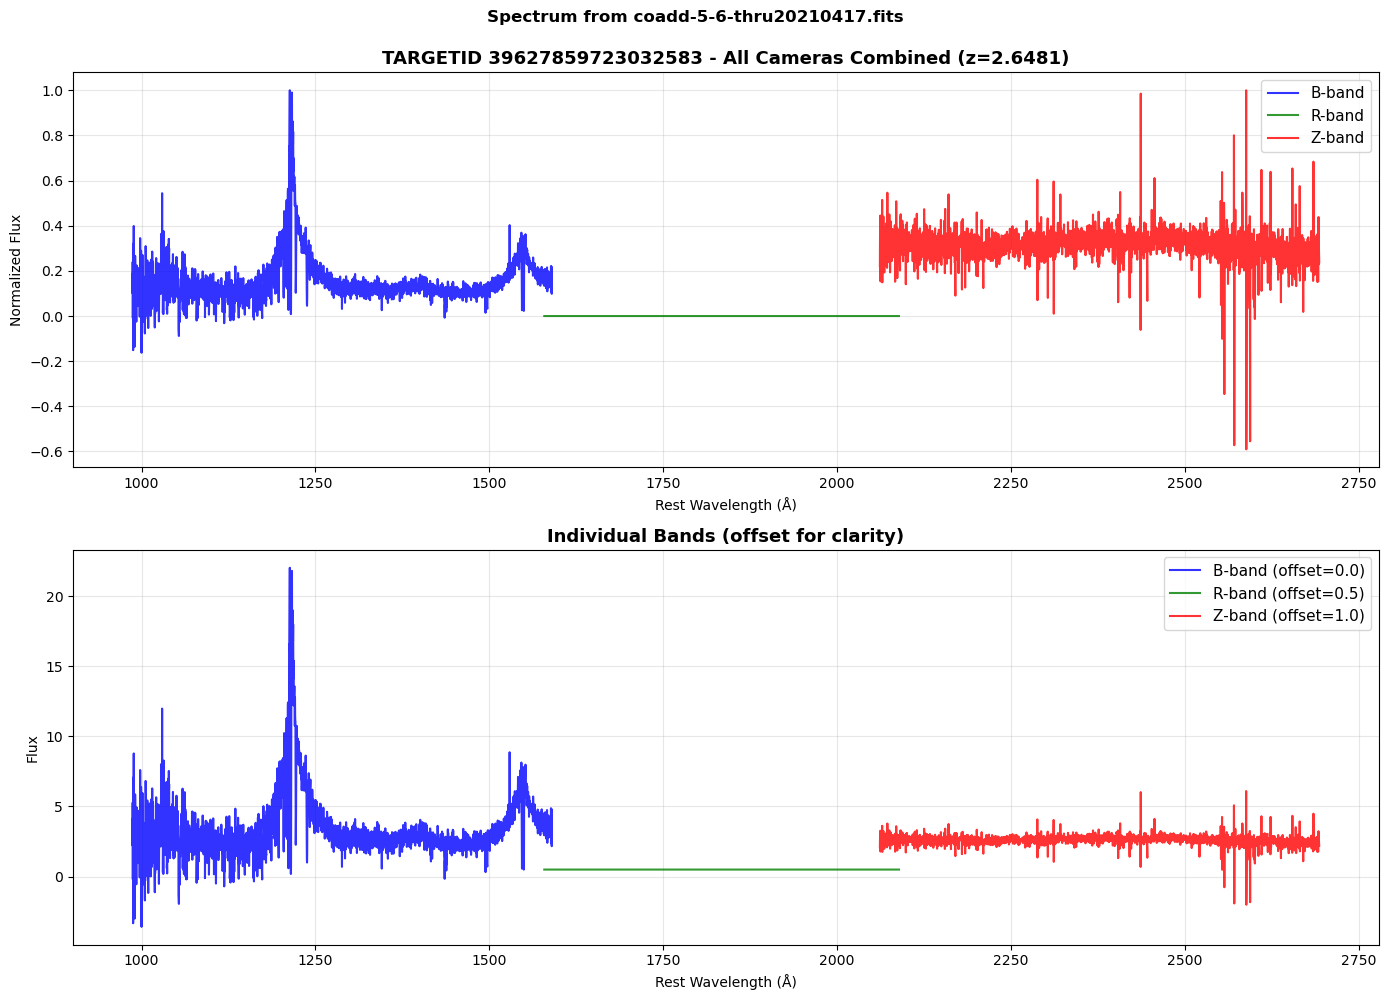


=== Combined Spectrum Details ===
Fiber index: 143
Redshift: 2.648059
Bands available: ['B', 'R', 'Z']
  B: 2751 pixels | Observed: 3600.0-5800.0 Å | Rest: 986.8-1589.9 Å
  R: 2326 pixels | Observed: 5760.0-7620.0 Å | Rest: 1578.9-2088.8 Å
  Z: 2881 pixels | Observed: 7520.0-9824.0 Å | Rest: 2061.4-2692.9 Å


In [102]:
if found:
    # Get redshift from catalog
    z_qso = result['Z'].values[0]
    
    # Create figure with combined and individual views
    bands_available = list(spectrum_data['bands'].keys())
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Color map for bands
    colors = {'B': 'blue', 'R': 'green', 'Z': 'red'}
    
    # Top plot: All bands combined
    for band in bands_available:
        band_data = spectrum_data['bands'][band]
        wavelength_obs = band_data['wavelength']
        flux_obs = band_data['flux']
        
        # Convert to rest frame
        wavelength_rest = wavelength_obs / (1.0 + z_qso)
        
        # Normalize flux for visualization (optional, remove if you want raw flux)
        flux_normalized = flux_obs / np.max(np.abs(flux_obs)) if np.max(np.abs(flux_obs)) > 0 else flux_obs
        
        axes[0].plot(wavelength_rest, flux_normalized, color=colors.get(band, 'black'), 
                    linewidth=1.5, label=f'{band}-band', alpha=0.8)
    
    axes[0].set_title(f'TARGETID {target_id} - All Cameras Combined (z={z_qso:.4f})', 
                     fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Rest Wavelength (Å)')
    axes[0].set_ylabel('Normalized Flux')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper right', fontsize=11)
    
    # Bottom plot: Individual bands stacked
    for idx, band in enumerate(bands_available):
        band_data = spectrum_data['bands'][band]
        wavelength_obs = band_data['wavelength']
        flux_obs = band_data['flux']
        
        # Convert to rest frame
        wavelength_rest = wavelength_obs / (1.0 + z_qso)
        
        # Offset for stacking visualization
        offset = idx * 0.5
        axes[1].plot(wavelength_rest, flux_obs + offset, color=colors.get(band, 'black'), 
                    linewidth=1.5, label=f'{band}-band (offset={offset})', alpha=0.8)
    
    axes[1].set_title(f'Individual Bands (offset for clarity)', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Rest Wavelength (Å)')
    axes[1].set_ylabel('Flux')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='upper right', fontsize=11)
    
    plt.suptitle(f'Spectrum from {spectrum_data["file"].split("/")[-1]}', 
                fontsize=12, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== Combined Spectrum Details ===")
    print(f"Fiber index: {spectrum_data['fiber_idx']}")
    print(f"Redshift: {z_qso:.6f}")
    print(f"Bands available: {bands_available}")
    for band in bands_available:
        nwave = len(spectrum_data['bands'][band]['flux'])
        wave_obs = spectrum_data['bands'][band]['wavelength']
        wave_rest = wave_obs / (1.0 + z_qso)
        print(f"  {band}: {nwave} pixels | Observed: {wave_obs[0]:.1f}-{wave_obs[-1]:.1f} Å | Rest: {wave_rest[0]:.1f}-{wave_rest[-1]:.1f} Å")
else:
    print("No spectrum found. Run the search cell first.")

In [103]:
# ========== Run SpenderQ on found spectrum (B and Z cameras only) ==========
if found:
    z_qso = result['Z'].values[0]
    
    # Use only B and Z cameras (skip R)
    selected_bands = ['B', 'Z']
    
    print(f"Processing TARGETID {target_id} with {selected_bands} cameras only")
    print(f"Redshift: {z_qso:.6f}\n")
    
    spender_results = {}
    
    for band in selected_bands:
        print(f"\n{'='*60}")
        print(f"Processing {band}-band")
        print('='*60)
        
        if band not in spectrum_data['bands']:
            print(f"  ✗ {band}-band not available")
            continue
        
        band_data = spectrum_data['bands'][band]
        flux_band = band_data['flux']
        ivar_band = band_data['ivar']
        
        print(f"  Flux shape: {flux_band.shape}")
        print(f"  iVar shape: {ivar_band.shape}")
        
        # Reshape to (1, Nwave) for single spectrum
        flux_single = flux_band.reshape(1, -1)
        ivar_single = ivar_band.reshape(1, -1)
        z_single = np.array([z_qso], dtype=np.float32)
        
        # Convert to torch tensors
        spec_tensor = torch.tensor(flux_single, dtype=torch.float32)
        w_tensor = torch.tensor(ivar_single, dtype=torch.float32)
        z_tensor = torch.tensor(z_single, dtype=torch.float32)
        
        print(f"  Running SpenderQ.eval()...")
        try:
            s, recon = spender.eval(spec_tensor, w_tensor, z_tensor)
        except IndexError as e:
            print(f"  IndexError in Lyα absorption: {e}")
            print(f"  Trying encode/decode without Lyα masking...")
            with torch.no_grad():
                spender.models[0][0].eval()
                s = spender.models[0][0].encode(spec_tensor)
                recon = np.array(spender.models[0][0].decode(s))
        
        spender_results[band] = {
            'flux': flux_band,
            'ivar': ivar_band,
            'wavelength': band_data['wavelength'],
            'latent': s,
            'recon': recon
        }
        
        print(f"  ✓ Latent shape: {s.shape}")
        print(f"  ✓ Reconstruction shape: {recon.shape}")
    
    print(f"\n{'='*60}")
    print(f"✓ SpenderQ processing complete!")
    print(f"{'='*60}")
else:
    print("No spectrum found. Run the search cell first.")

Processing TARGETID 39627859723032583 with ['B', 'Z'] cameras only
Redshift: 2.648059


Processing B-band
  Flux shape: (2751,)
  iVar shape: (2751,)
  Running SpenderQ.eval()...
  IndexError in Lyα absorption: boolean index did not match indexed array along dimension 0; dimension is 2751 but corresponding boolean dimension is 7781
  Trying encode/decode without Lyα masking...
  ✓ Latent shape: torch.Size([1, 10])
  ✓ Reconstruction shape: (1, 9780)

Processing Z-band
  Flux shape: (2881,)
  iVar shape: (2881,)
  Running SpenderQ.eval()...
  IndexError in Lyα absorption: boolean index did not match indexed array along dimension 0; dimension is 2881 but corresponding boolean dimension is 7781
  Trying encode/decode without Lyα masking...
  ✓ Latent shape: torch.Size([1, 10])
  ✓ Reconstruction shape: (1, 9780)

✓ SpenderQ processing complete!


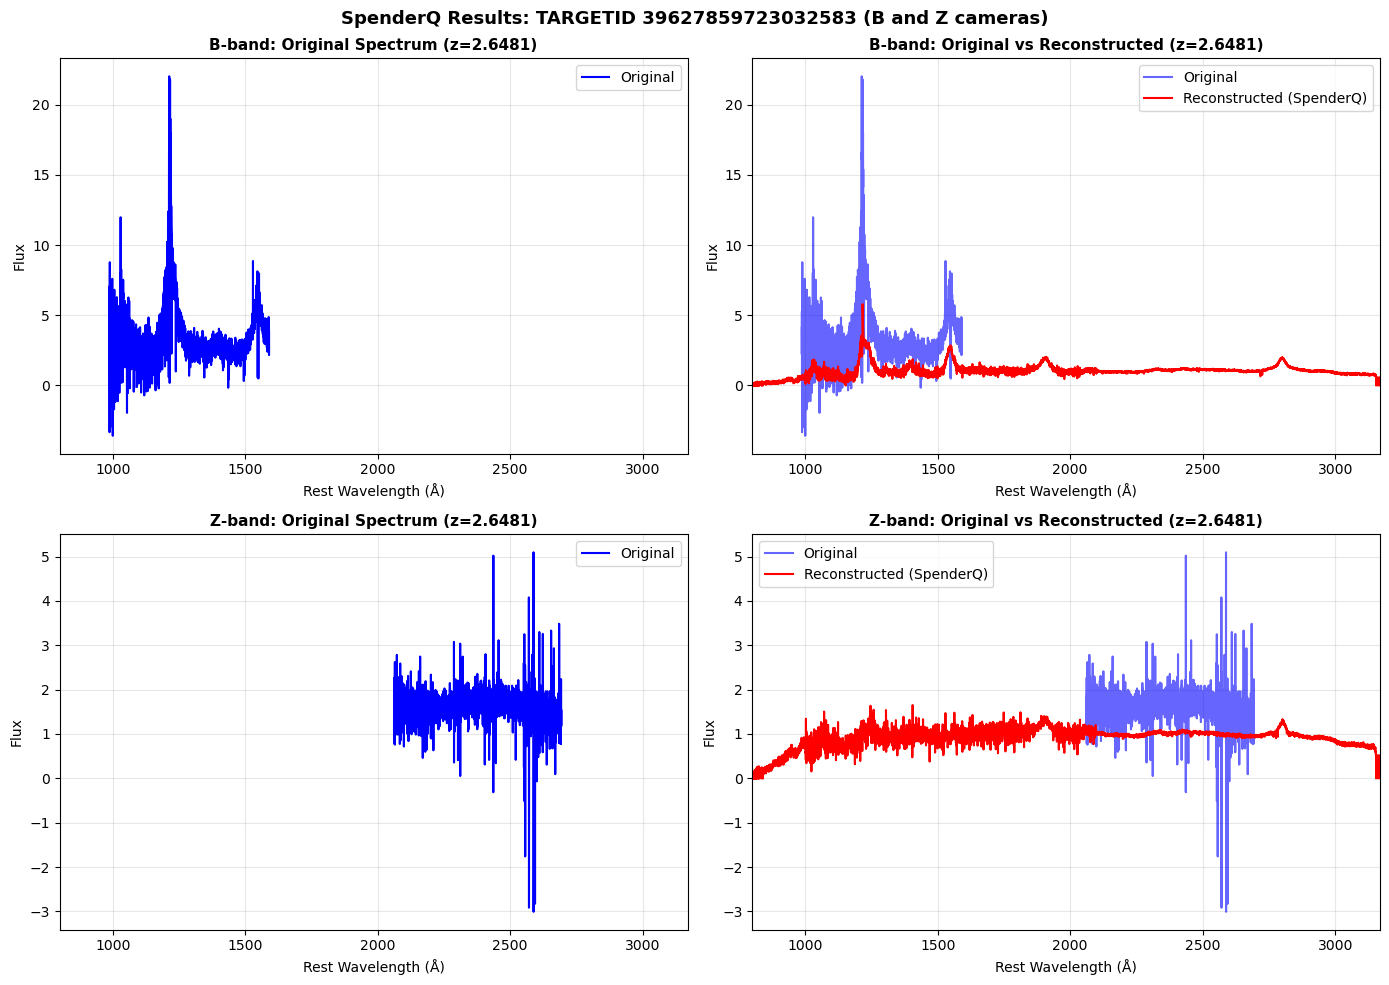


=== SpenderQ Latent Representations ===
B-band latent shape: torch.Size([1, 10])
  Latent vector (first 10 dims): tensor([ 2.0638,  1.3236, -1.3181, -2.1508,  1.3108,  0.4560,  2.1544, -1.7015,
         1.2429, -3.1218])
Z-band latent shape: torch.Size([1, 10])
  Latent vector (first 10 dims): tensor([ 2.0389,  1.5672,  0.6132, -1.2399,  0.6450, -0.5387, -0.4984, -1.8508,
         0.0833, -3.4209])


In [104]:
if found and spender_results:
    z_qso = result['Z'].values[0]
    wave_recon = spender.wave_recon()
    
    # Create figure with original vs reconstructed for each band
    n_bands = len(spender_results)
    fig, axes = plt.subplots(n_bands, 2, figsize=(14, 5*n_bands))
    if n_bands == 1:
        axes = axes.reshape(1, -1)
    
    for ax_idx, band in enumerate(sorted(spender_results.keys())):
        result_band = spender_results[band]
        flux = result_band['flux']
        wavelength = result_band['wavelength']
        recon = result_band['recon'][0]  # First (only) spectrum
        
        # Convert to rest frame
        wavelength_rest = wavelength / (1.0 + z_qso)
        
        # Left plot: Original spectrum
        axes[ax_idx, 0].plot(wavelength_rest, flux, 'b-', linewidth=1.5, label='Original')
        axes[ax_idx, 0].set_title(f'{band}-band: Original Spectrum (z={z_qso:.4f})', fontsize=11, fontweight='bold')
        axes[ax_idx, 0].set_xlabel('Rest Wavelength (Å)')
        axes[ax_idx, 0].set_ylabel('Flux')
        axes[ax_idx, 0].grid(True, alpha=0.3)
        axes[ax_idx, 0].legend(fontsize=10)
        
        # Right plot: Original + Reconstructed overlapped
        axes[ax_idx, 1].plot(wavelength_rest, flux, 'b-', linewidth=1.5, label='Original', alpha=0.6)
        axes[ax_idx, 1].plot(wave_recon, recon, 'r-', linewidth=1.5, label='Reconstructed (SpenderQ)')
        axes[ax_idx, 1].set_title(f'{band}-band: Original vs Reconstructed (z={z_qso:.4f})', fontsize=11, fontweight='bold')
        axes[ax_idx, 1].set_xlabel('Rest Wavelength (Å)')
        axes[ax_idx, 1].set_ylabel('Flux')
        axes[ax_idx, 1].grid(True, alpha=0.3)
        axes[ax_idx, 1].legend(fontsize=10)
        
        # Unify wavelength range
        wave_min = wave_recon.min()
        wave_max = wave_recon.max()
        axes[ax_idx, 0].set_xlim(wave_min, wave_max)
        axes[ax_idx, 1].set_xlim(wave_min, wave_max)
    
    plt.suptitle(f'SpenderQ Results: TARGETID {target_id} (B and Z cameras)', 
                fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== SpenderQ Latent Representations ===")
    for band in sorted(spender_results.keys()):
        latent = spender_results[band]['latent']
        print(f"{band}-band latent shape: {latent.shape}")
        print(f"  Latent vector (first 10 dims): {latent[0][:10]}")
else:
    print("No SpenderQ results found. Run the SpenderQ processing cell first.")

## coadd-5-6-20210417.fits
### the exact same id but from pernight instead of cumulative

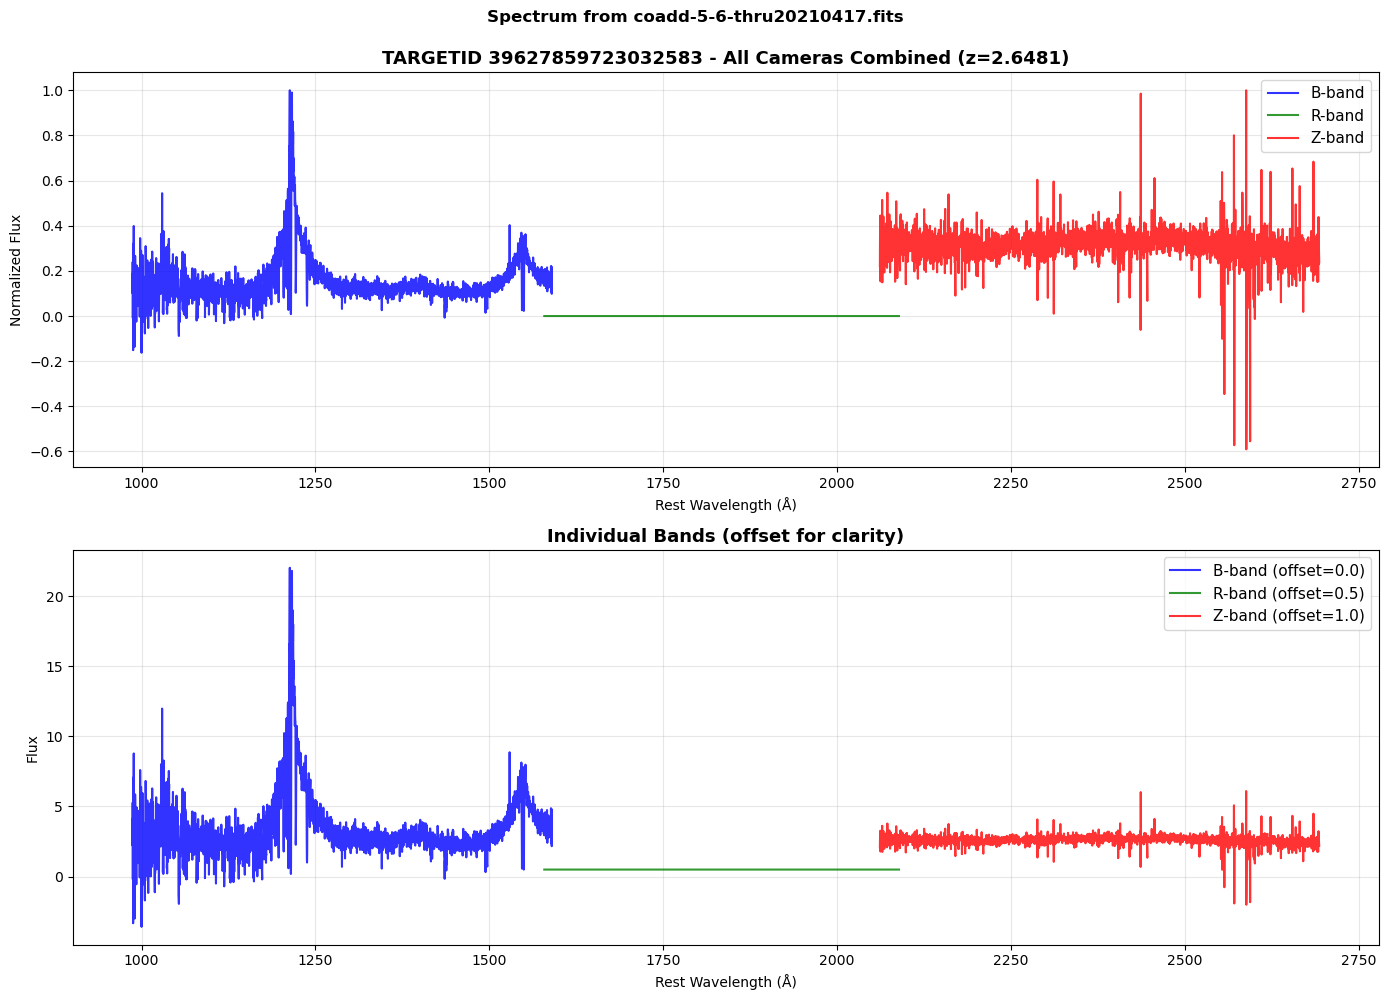


=== Combined Spectrum Details ===
Fiber index: 143
Redshift: 2.648059
Bands available: ['B', 'R', 'Z']
  B: 2751 pixels | Observed: 3600.0-5800.0 Å | Rest: 986.8-1589.9 Å
  R: 2326 pixels | Observed: 5760.0-7620.0 Å | Rest: 1578.9-2088.8 Å
  Z: 2881 pixels | Observed: 7520.0-9824.0 Å | Rest: 2061.4-2692.9 Å


In [105]:
pernight_path= '/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/pernight/6/20210417/coadd-5-6-20210417.fits'
target_id = 39627859723032583

if found:
    # Get redshift from catalog
    z_qso = result['Z'].values[0]
    
    # Create figure with combined and individual views
    bands_available = list(spectrum_data['bands'].keys())
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Color map for bands
    colors = {'B': 'blue', 'R': 'green', 'Z': 'red'}
    
    # Top plot: All bands combined
    for band in bands_available:
        band_data = spectrum_data['bands'][band]
        wavelength_obs = band_data['wavelength']
        flux_obs = band_data['flux']
        
        # Convert to rest frame
        wavelength_rest = wavelength_obs / (1.0 + z_qso)
        
        # Normalize flux for visualization (optional, remove if you want raw flux)
        flux_normalized = flux_obs / np.max(np.abs(flux_obs)) if np.max(np.abs(flux_obs)) > 0 else flux_obs
        
        axes[0].plot(wavelength_rest, flux_normalized, color=colors.get(band, 'black'), 
                    linewidth=1.5, label=f'{band}-band', alpha=0.8)
    
    axes[0].set_title(f'TARGETID {target_id} - All Cameras Combined (z={z_qso:.4f})', 
                     fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Rest Wavelength (Å)')
    axes[0].set_ylabel('Normalized Flux')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper right', fontsize=11)
    
    # Bottom plot: Individual bands stacked
    for idx, band in enumerate(bands_available):
        band_data = spectrum_data['bands'][band]
        wavelength_obs = band_data['wavelength']
        flux_obs = band_data['flux']
        
        # Convert to rest frame
        wavelength_rest = wavelength_obs / (1.0 + z_qso)
        
        # Offset for stacking visualization
        offset = idx * 0.5
        axes[1].plot(wavelength_rest, flux_obs + offset, color=colors.get(band, 'black'), 
                    linewidth=1.5, label=f'{band}-band (offset={offset})', alpha=0.8)
    
    axes[1].set_title(f'Individual Bands (offset for clarity)', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Rest Wavelength (Å)')
    axes[1].set_ylabel('Flux')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='upper right', fontsize=11)
    
    plt.suptitle(f'Spectrum from {spectrum_data["file"].split("/")[-1]}', 
                fontsize=12, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== Combined Spectrum Details ===")
    print(f"Fiber index: {spectrum_data['fiber_idx']}")
    print(f"Redshift: {z_qso:.6f}")
    print(f"Bands available: {bands_available}")
    for band in bands_available:
        nwave = len(spectrum_data['bands'][band]['flux'])
        wave_obs = spectrum_data['bands'][band]['wavelength']
        wave_rest = wave_obs / (1.0 + z_qso)
        print(f"  {band}: {nwave} pixels | Observed: {wave_obs[0]:.1f}-{wave_obs[-1]:.1f} Å | Rest: {wave_rest[0]:.1f}-{wave_rest[-1]:.1f} Å")
else:
    print("No spectrum found. Run the search cell first.")

Checking pernight file: /Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/pernight/6/20210417/coadd-5-6-20210417.fits
Found TARGETID 39627859723032583 in pernight file at fiber index 143


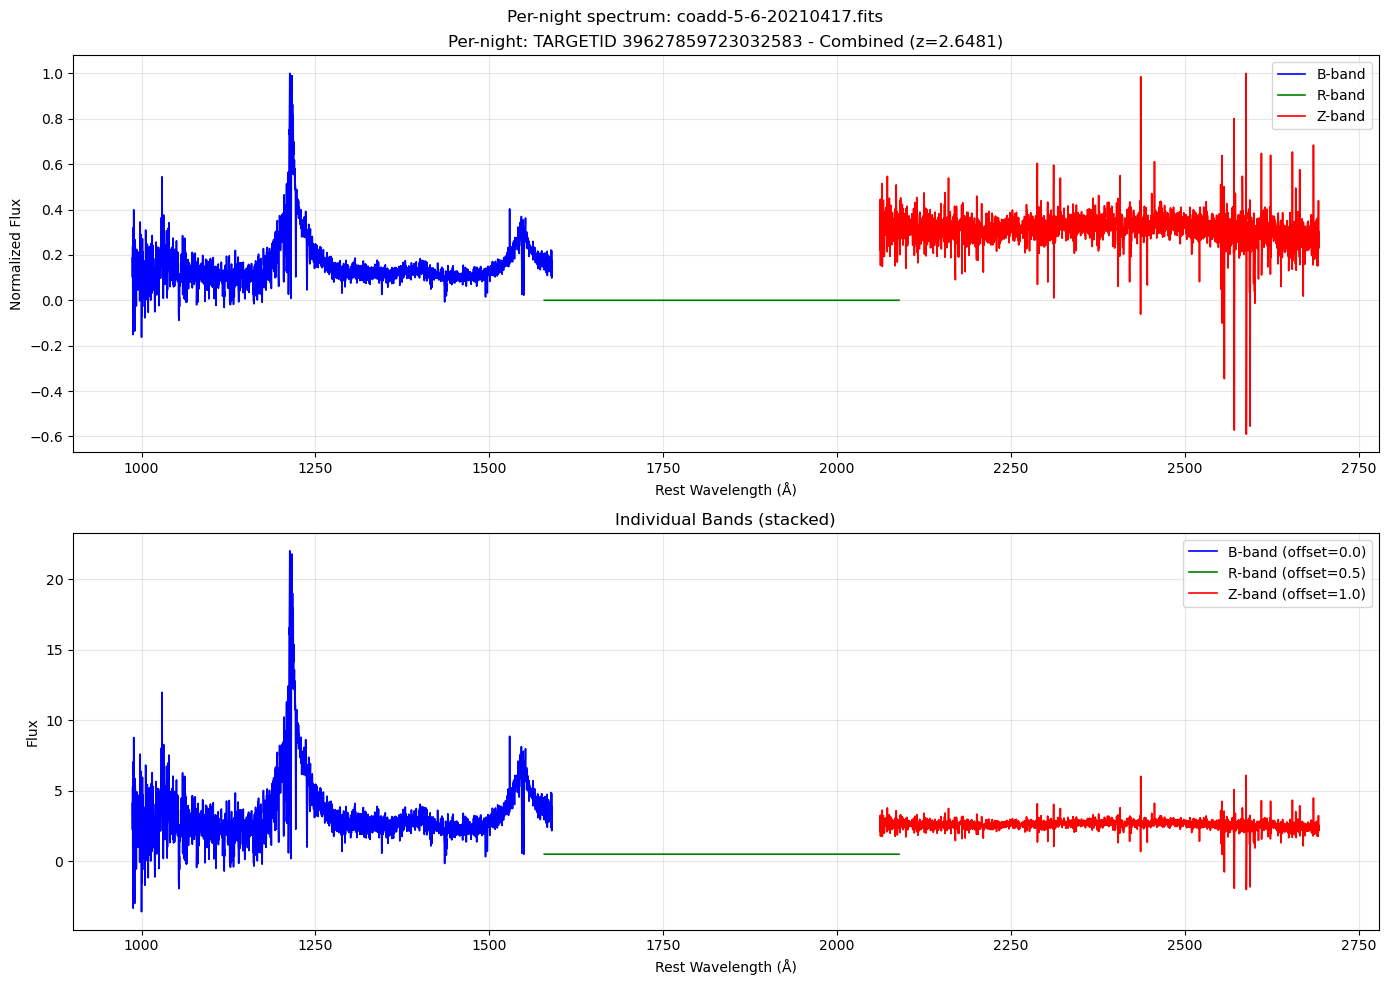

In [106]:
# Load pernight coadd and plot this TARGETID if present
pernight_path = '/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/pernight/6/20210417/coadd-5-6-20210417.fits'
target_id = 39627859723032583

print(f'Checking pernight file: {pernight_path}')
try:
    with fits.open(pernight_path) as hdul:
        if 'FIBERMAP' not in hdul:
            print('No FIBERMAP in pernight file')
        else:
            pfibermap = hdul['FIBERMAP'].data
            p_targetids = pfibermap['TARGETID']
            p_idx = np.where(p_targetids == target_id)[0]
            if len(p_idx) == 0:
                print(f'TARGETID {target_id} not found in pernight file')
            else:
                p_idx = p_idx[0]
                print(f'Found TARGETID {target_id} in pernight file at fiber index {p_idx}')
                pernight_spectrum = {'file': pernight_path, 'fiber_idx': p_idx, 'bands': {}}
                for band in ['B','R','Z']:
                    wkey = f'{band}_WAVELENGTH'
                    fkey = f'{band}_FLUX'
                    ivkey = f'{band}_IVAR'
                    if wkey in hdul and fkey in hdul and ivkey in hdul:
                        pernight_spectrum['bands'][band] = {
                            'wavelength': np.array(hdul[wkey].data, dtype=np.float32),
                            'flux': np.array(hdul[fkey].data[p_idx], dtype=np.float32),
                            'ivar': np.array(hdul[ivkey].data[p_idx], dtype=np.float32)
                        }
                # plotting (use redshift from catalog if available)
                if 'Z' in result.columns:
                    z_qso = result['Z'].values[0]
                else:
                    z_qso = 0.0
                bands_available = list(pernight_spectrum['bands'].keys())
                if len(bands_available) == 0:
                    print('No bands available in pernight file for this fiber')
                else:
                    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
                    colors = {'B':'blue','R':'green','Z':'red'}
                    for band in bands_available:
                        band_data = pernight_spectrum['bands'][band]
                        wavelength_obs = band_data['wavelength']
                        flux_obs = band_data['flux']
                        wavelength_rest = wavelength_obs / (1.0 + z_qso) if z_qso>0 else wavelength_obs
                        flux_normalized = flux_obs / np.max(np.abs(flux_obs)) if np.max(np.abs(flux_obs))>0 else flux_obs
                        axes[0].plot(wavelength_rest, flux_normalized, color=colors.get(band,'black'), linewidth=1.2, label=f'{band}-band')
                    axes[0].set_title(f'Per-night: TARGETID {target_id} - Combined (z={z_qso:.4f})')
                    axes[0].set_xlabel('Rest Wavelength (Å)')
                    axes[0].set_ylabel('Normalized Flux')
                    axes[0].grid(True, alpha=0.3)
                    axes[0].legend()

                    for idx, band in enumerate(bands_available):
                        band_data = pernight_spectrum['bands'][band]
                        wavelength_obs = band_data['wavelength']
                        flux_obs = band_data['flux']
                        wavelength_rest = wavelength_obs / (1.0 + z_qso) if z_qso>0 else wavelength_obs
                        offset = idx * 0.5
                        axes[1].plot(wavelength_rest, flux_obs + offset, color=colors.get(band,'black'), linewidth=1.2, label=f'{band}-band (offset={offset})')
                    axes[1].set_title('Individual Bands (stacked)')
                    axes[1].set_xlabel('Rest Wavelength (Å)')
                    axes[1].set_ylabel('Flux')
                    axes[1].grid(True, alpha=0.3)
                    axes[1].legend()
                    plt.suptitle(f'Per-night spectrum: {pernight_path.split('/')[-1]}')
                    plt.tight_layout()
                    plt.show()
except Exception as e:
    print(f'Error opening pernight file: {e}')